In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.utils.data as Data
import math
import time

#tds
import torchvision

#git
#from __future__ import print_function
#import argparse
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
from torchvision.datasets import MNIST
from torchvision.transforms import Compose, ToTensor, Normalize, Resize
from torch.utils.data import DataLoader

In [2]:
def get_data_loaders(train_batch_size, test_batch_size, size=(224,224)):

    mnist = MNIST('data/', download=False, train=True).train_data.float()

    data_transform = Compose([ Resize(size) ,ToTensor(), Normalize((mnist.mean()/255,), (mnist.std()/255,))])

    train_loader = DataLoader(MNIST('data/', download=True, transform=data_transform, train=True),
                              batch_size=train_batch_size, shuffle=True)

    test_loader = DataLoader(MNIST('data/', download=False, transform=data_transform, train=False),
                            batch_size=test_batch_size, shuffle=False)

    print('loaded the mnist data')
    return train_loader, test_loader


In [3]:
# counts trainable weights in a model
def count_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [4]:
# Base for ResNet
# Vill ha bilder av storlek 224x224
def conv3x3(in_planes, out_planes, stride=1, groups=1, dilation=1):
    """3x3 convolution with padding"""
    # torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, 
    # dilation=1, groups=1, bias=True, padding_mode='zeros')
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=dilation, groups=groups, bias=False, dilation=dilation)

def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)


class BasicBlock(nn.Module):
    expansion = 1
    def __init__(self, inplanes, planes, stride=1, downsample=None):
        """
        planes is the number of filters we want
        inplanes can differ from planes as we can get inputs from multiple places
        """
        super(BasicBlock, self).__init__()
        
        norm_layer = nn.BatchNorm2d
        groups=1,
        base_width=64
        dilation = 1
        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        
        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


In [27]:
class ResNet(nn.Module):
    # ResNet(BasicBlock, [2, 2, 2, 2])
    def __init__(self, block, layers, num_classes=10):
        super(ResNet, self).__init__()
        
        norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer
        self.inplanes = 64
        
        self.groups = 1
        self.base_width = 64
        # Första filtret för ResNet "börjar"
        self.conv1 = nn.Conv2d(1, self.inplanes, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        # ResNet
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        
        # Slutfas
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)
        
        # What is this???
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
                
        # might want to Zero-initialize the last BN in each residual branch here

    def _make_layer(self, block, planes, blocks, stride=1):
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = 1
        dilate=False
        
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion  # block expansion = 1 for basic block
        
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def _forward_impl(self, x):
        # See note [TorchScript super()]
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        # We do not need softmax since it is done inside nn.CrossEntropyLoss()
        return x

    def forward(self, x):
        return self._forward_impl(x)

#ResNet(BasicBlock, [2, 2, 2, 2])
#print(ResNet(BasicBlock, [1,1,1,1]))

count_params(ResNet(BasicBlock, [2,2,2,2]))

11175370

In [5]:
class myResNet(nn.Module):
    # ResNet(BasicBlock, [2, 2, 2, 2])
    def __init__(self, block, filters, nbr_blocks):
        super(myResNet, self).__init__()
        
        num_classes = 10
        norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer
        self.inplanes = filters[0]  # 64
        
        # self.groups = 1
        #self.base_width = 64
        # Första filtret för ResNet "börjar"
        self.conv1 = nn.Conv2d(1, self.inplanes, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        # ResNet for NAS
        reslays = len(nbr_blocks)
        self.reslays = reslays
        for idx in range(reslays):
            key = 'layer' + str(idx+1)
            print('init: ', key)
            f = filters[idx + 1] # first was for the 7x7
            b = nbr_blocks[idx]
                        
            if idx == 0:
                lay = self._make_layer(block, f, b)
            else:
                lay = self._make_layer(block, f, b, stride=2)
            
            setattr(self, key, lay)
        """    
        # ResNet regular    
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        """
        # Slutfas
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        
        out_planes = filters[-1]
        self.fc = nn.Linear(out_planes * block.expansion, num_classes)
        
        # What is this???
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
                
        # might want to Zero-initialize the last BN in each residual branch here

    def _make_layer(self, block, planes, blocks, stride=1):
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = 1
        dilate=False
        
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion  # block expansion = 1 for basic block
        
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def _forward_impl(self, x):
        # See note [TorchScript super()]
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        #print(x.shape)
        
        # NAS pass
        for idx in range(self.reslays):
            key = 'layer' + str(idx+1)
            #print('fp: ', key)
            x = getattr(self, key)(x)
            #print(x.shape)
        
        """
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        """        
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        # We do not need softmax since it is done inside nn.CrossEntropyLoss()
        return x

    def forward(self, x):
        return self._forward_impl(x)

    
# layer_data = [(64,1), (128,1), (254, 1), (512,1)]
fil = [64, 64,128,254,512]
blk = [1,1,1,1]
layer_data = (fil,blk)

#myResNet(BasicBlock, layer_data)
#print(myResNet(BasicBlock, layer_data))

count_params(myResNet(BasicBlock, *layer_data))

init:  layer1
init:  layer2
init:  layer3
init:  layer4


4882658

In [14]:
class RNsmall(nn.Module):
    def __init__(self, block, layers, num_classes=10):
        super(RNsmall, self).__init__()
        
        norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer
        self.inplanes = 16
        
        # Första filtret för ResNet "börjar"
        self.conv1 = nn.Conv2d(1, self.inplanes, kernel_size=3, stride=1, padding=1,
                               bias=False)
        self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        # self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        # ResNet
        self.layer1 = self._make_layer(block, 16, layers[0])
        self.layer2 = self._make_layer(block, 32, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 64, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 128, layers[3], stride=2)

        # Slutfas
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(128 * block.expansion, num_classes)
        
        # What is this???
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
                
        # might want to Zero-initialize the last BN in each residual branch here

    def _make_layer(self, block, planes, blocks, stride=1):
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = 1
        dilate=False
        
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion  # block expansion = 1 for basic block
        
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def _forward_impl(self, x):
        # See note [TorchScript super()]
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        
        # The blocks should have identity mapping (method A) for residuals
        x = self.layer1(x)
        #print(x.shape)
        x = self.layer2(x)
        #print(x.shape)
        x = self.layer3(x)
        #print(x.shape)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        # We do not need softmax since it is done inside nn.CrossEntropyLoss()
        return x

    def forward(self, x):
        return self._forward_impl(x)

#ResNet(BasicBlock, [2, 2, 2, 2])
#print(ResNet(BasicBlock, [1,1,1,1]))
n = 2
print('small resnet of deepth ', 8*n + 2)
count_params(RNsmall(BasicBlock, [n,n,n,n]))

small resnet of deepth  18


701178

In [15]:
n_epochs = 1
batch_size_train = 128
batch_size_test = 1000
# learning_rate = 0.1
# momentum = 0.5
#log_interval = 10
size = (32,32)     # ResNet is made for 224, Mnist is 28, Cifar-10 is 32
train_loader, test_loader = get_data_loaders(batch_size_train, batch_size_test, size=size)
examples = enumerate(train_loader)
batch_idx, (example_data, example_targets) = next(examples)
print('input: ', example_data.shape)
criterion = nn.CrossEntropyLoss()    

# Call myResNet
# fil = [16, 64,4, 32]
# blk = [1,1,1]
# layer_data = (fil,blk)
# layer_data = [(64,1), (128,1), (254, 1), (512,1)]
# network = myResNet(BasicBlock, *layer_data)

# Call RNsmall
n = 2
print('small resnet of deepth ', 8*n + 2)
network = RNsmall(BasicBlock, [n,n,n,n])

print('params: ', count_params(network))

dataiter = iter(train_loader)
images, labels = dataiter.next()
outputs = network(images)

optimizer = optim.Adam(network.parameters())

#outputs[0]

loaded the mnist data
input:  torch.Size([128, 1, 32, 32])
small resnet of deepth  18
params:  701178


In [18]:
# tog typ en kvart
t0 = time.perf_counter()
for epoch in range(n_epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = network(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 100 == 99:    # print every 20 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 100))
            running_loss = 0.0

print('Finished Training it took ', (time.perf_counter() - t0)/60, ' minutes to train')

[1,   100] loss: 0.032
[1,   200] loss: 0.049
[1,   300] loss: 0.030
[1,   400] loss: 0.039
Finished Training it took  10.605562066282921  minutes to train


In [19]:
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = network(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
   
print('Accuracy of the network on the 10000 test images: %f %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 99.120000 %


In [21]:
98% på 8 min med [1,1,1,1]
98.3% på 15 min med |2,2,2,2]
99.1% på 11 min (5 eps) med fil = [16, 64,128], blk = [1,1]

10.44

In [22]:
print('Accuracy of the network on the 10000 test images: %f %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 10.440000 %


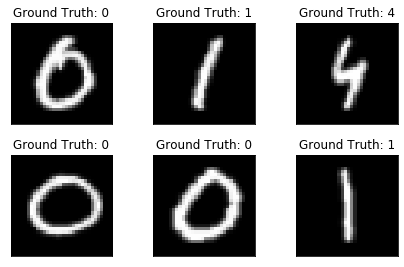

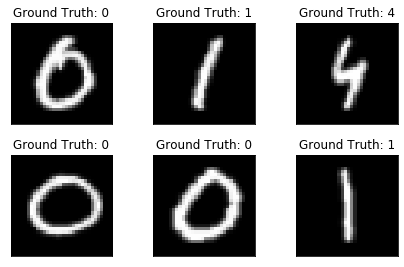

In [54]:
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
fig